# Detecting chaotic dynamics with the fast Fourier transform

In this notebook, we will revisit the period doubling route to chaos, and use the fast Fourier transform to detect the onset of chaos. This will allow to understand the relationship between the power spectrum of a signal and the underlying dynamics of the system that generated it, as well as to explore the the Fast Fourier Transform (FFT) algorithm as an example of a *divide-and-conquer* algorithm with runtime complexity $N \log N$.

Preamble: Run the cells below to import the necessary Python packages

 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/fast_fourier.ipynb)

In [17]:
import numpy as np

# Wipe all outputs from this notebook
# from IPython.display import Image, clear_output, display
# clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Revisiting the period doubling route to chaos

In an earlier notebook, we analyzed the logistic map, a deterministic discrete-time dynamical system:

$$x_{n+1} = f(x_n) = r x_n (1 - x_n)$$

where $x_n$ is the population at time $n$ and $r$ is a parameter that controls the growth rate of the population in each generation. Recall that, as $r$ increases, the system undergoes a series of bifurcations, from a stable fixed point to a period-2 cycle to a period-4 cycle, period-8, and so on, until it reaches a critical value of $r$ at which the system becomes chaotic.

This mechanism is observed in many other physical systems, including, famously, in the velocity fluctuations of a rotating fluid flow as the rotation speed is increased. The flow fluctuations gradually double in frequency, then double again, and so on, until the flow becomes fully turbulent.

### What does the period doubling look like in the frequency domain?


<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/CouetteTaylorSystem.png" alt="Taylor-Couette System" style="width: 300px;"/>

*Image from [Wikipedia](https://en.wikipedia.org/wiki/Taylor%E2%80%93Couette_flow#/media/File:CouetteTaylorSystem.svg)*

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/doubling.png" alt="Taylor-Couette Experiment" style="width: 750px;"/>

*Image from [source](https://www.sciencetalks-journal.com/article/S2772-5693%2822%2900115-3/pdf)*

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/WillametteTaylorCouetteRot2.png" alt="Taylor-Couette Experiment" style="width: 750px;"/>

*Image from [source](https://advlabs.aapt.org/wiki/Taylor-Couette_Flow)*

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## A low-dimensional model of period doubling in continuous time

Simulating a full turbulent flow in 3D typically requires simulating the Navier-Stokes equations, a set of partial differential equations that describe the motion of a fluid. Numerically, we often discretize partial differential equations on a grid and solve a system of coupled ordinary differential equations at each grid point. This is much higher dimensional than the dynamical systems that we have previously studied, which have all been in two or three dimensions.

Fortunately, the period-doubling route to chaos can be observed in much lower-dimensional systems, which capture the essential features of the transition to turbulence. One such system is the Rossler system, a three-dimensional continuous-time dynamical system. We can think of the Rossler coordinates as "bulk" measurements of the fluid flow, such as the average velocity across the domain, average pressure, and average acceleration.

#### Implementing the Rossler system in Python

Our implementation of the Rossler system will resemble previous dynamical systems that we have studied in this course. However, the Rossler system is a continuous-time system of the form:

$$\frac{d}{dt}\mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t))$$

where $\mathbf{x}(t)$ is a three-dimensional and $\mathbf{f}(\mathbf{x})$ is a three-dimensional vector field. Because the Rossler system is a continuous-time system, we will need to use a numerical integrator to solve the system of ordinary differential equations. We will learn about integration in a different course module, but for now, we will use the `solve_ivp` function from the `scipy.integrate` module. This function takes a callable right-hand side function, an initial condition, and a time interval, and returns the solution to the system of ordinary differential equations.


Text(0, 0.5, 'y')

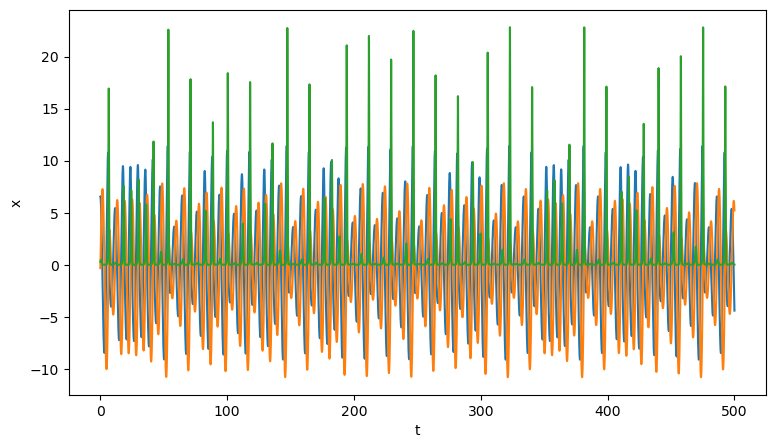

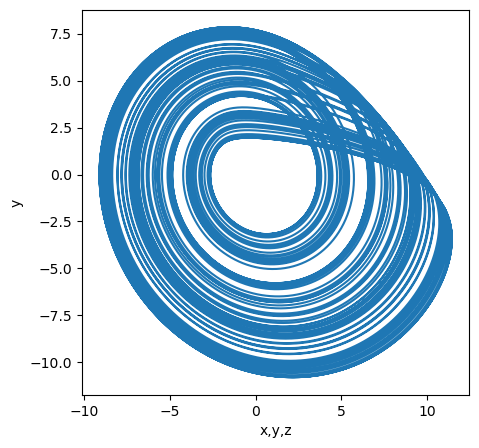

In [18]:
# Import a built-in function that numerically solves ordinary differential equations
from scipy.integrate import solve_ivp

class Rossler:
    """
    A continuous-time dynamical system that exhibits some properties associated with
    velocity fluctuations in turbulent fluid flow. The parameter c can b thought of as
    increasing the speed of an experimental fluid flow.
    """

    def __init__(self, a=0.2, b=0.2, c=5.7):
        self.a = a
        self.b = b
        self.c = c

    def rhs(self, t, x):
        """
        This function takes a point x in phase space and returns the time derivative
        vector at that point

        Takes a 3 x 1 state vector and returns a 3 x 1 vector of time derivative value
        """
        # x.shape = 3
        return np.array([-x[1] - x[2],
                         x[0] + self.a * x[1],
                         self.b + x[2] * (x[0] - self.c)])

    def solve(self, t_span, x0, **kwargs):
        """
        This function numerically solves the differential equations for the Rossler
          system given an initial condition and a time span.
        """
        ## Can manually integrate the system using the forward Euler method
        # for i in range(1000):
        #     x += dt * self.rhs(t, x)
        return solve_ivp(self.rhs, t_span, x0, method="Radau", **kwargs)

## Define the initial conditions and time span over which we want to solve the system
ic = np.array([6.55, -0.317,  0.284])
t_span = [0, 500]
model = Rossler()

## Solve the system and plot the results
sol = model.solve(t_span, ic, max_step=0.01)
plt.figure(figsize=(9, 5))
plt.plot(sol.t, sol.y.T)
plt.xlabel('t')
plt.ylabel('x')

plt.figure(figsize=(5, 5))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('x,y,z')
plt.ylabel('y')



We will vary the value of a parameter $c$ in the system, which is analogous to the Reynolds number in fluid dynamics, in order drive the system into the turbulent (chaotic) regime through a period doubling sequence.

Text(0.5, 1.0, 'c = 5.8')

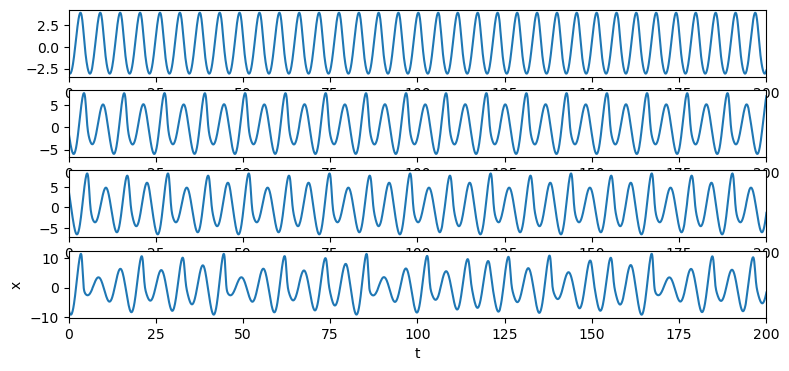

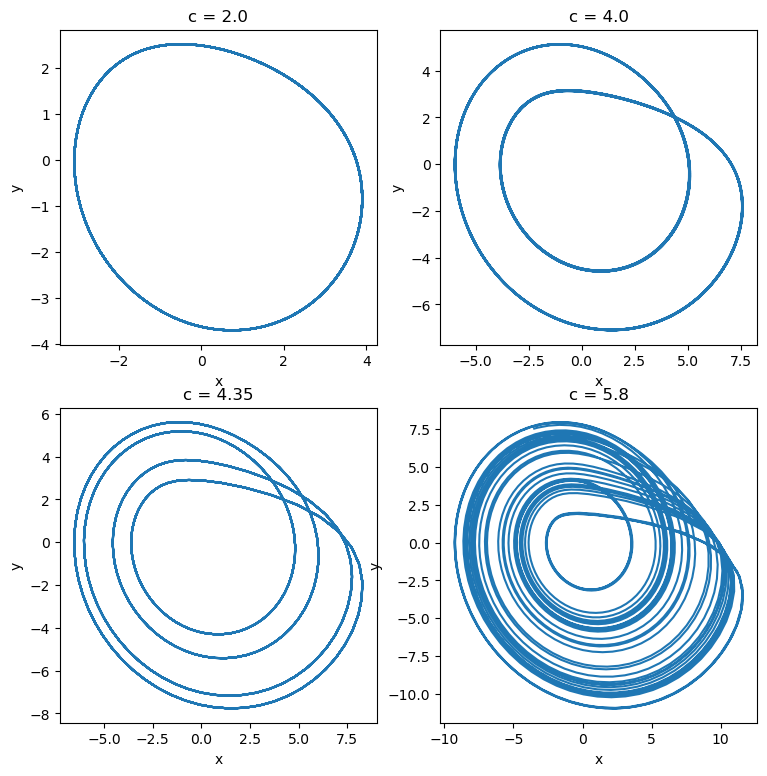

In [19]:
ic = np.array([6.55, -0.317,  0.284])
t_span = [0, 500]

model = Rossler()

model.c = 2.0
sol = model.solve(t_span, ic, max_step=0.1)
y2 = sol.y.T[-2048:]

model.c = 3.8
sol = model.solve(t_span, ic, max_step=0.1)
y4 = sol.y.T[-2048:]

model.c = 4.1
sol = model.solve(t_span, ic, max_step=0.1)
y8 = sol.y.T[-2048:]

model.c = 5.8
sol = model.solve(t_span, ic, max_step=0.1)
yc = sol.y.T[-2048:]

t = sol.t[:2048]

plt.figure(figsize=(9, 4))
plt.subplot(4, 1, 1)
plt.plot(t, y2[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 2)
plt.plot(t, y4[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 3)
plt.plot(t, y8[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 4)
plt.plot(t, yc[:, 0])
plt.xlim(0, 200)
plt.xlabel('t')
plt.ylabel('x')


plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.plot(y2[:, 0], y2[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 2.0')

plt.subplot(2, 2, 2)
plt.plot(y4[:, 0], y4[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 4.0')

plt.subplot(2, 2, 3)
plt.plot(y8[:, 0], y8[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 4.35')

plt.subplot(2, 2, 4)
plt.plot(yc[:, 0], yc[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 5.8')

# plt.figure(figsize=(9, 5))
# plt.plot(sol.t, sol.y.T)
# plt.xlabel('t')
# plt.ylabel('x')

# The discrete Fourier Transform



Suppose that we want to analyze a signal $x(t)$ that is a function of time. We can think of this signal as a sum of sines of different frequencies, amplitudes, and phases:

$$
    x(t) = \sum_{k=0}^{\infty} A_k \sin\left(2\pi k \frac{t}{T} + \phi_k\right)
$$


Where $A_k \in \mathbb{R}$ is the amplitude of the $k^{th}$ sinusoid and $\phi_k \in \mathbb{R}$ is its phase of the $k^{th}$ sinusoid. We could alternatively remove the phase term and write the signal as a sum of sines and cosines (which would have their own amplitudes).

We can also write the signal in terms of complex exponentials:

$$
    x(t) = \sum_{k=0}^{\infty} a_k e^{2\pi i k \frac{t}{T}}
$$

where we have absorbed the amplitude and phase into the complex amplitude $a_k = A_k e^{i\phi_k} \in \mathbb{C}$.

Technically, the Fourier transform only describes periodic signals with a finite period $T$. However, when working with real time series, we often set $T$ equal to the longest "resolvable" period in the signal, which would be the length of the time series itself.



The **Discrete Fourier transform (DFT)** is an algorithm that allows us to compute the amplitudes, frequencies, and phases of the sinusoids that make up a signal. It is an invertible integral transformation that maps a signal from the time domain to the frequency domain.

The **Power Spectral Density (PSD)** of a signal is the square of the amplitudes of the sinusoids that make up the signal:

$$
\text{PSD}(k) = |a_k|^2
$$

It ignores the phase information and simply tells us how much power is in each frequency bin. The Fourier transform is fully-invertible, it encodes the same information as the original signal in a different basis. The power spectrum is not invertible, because it discards the phase information.



(2048, 2048)


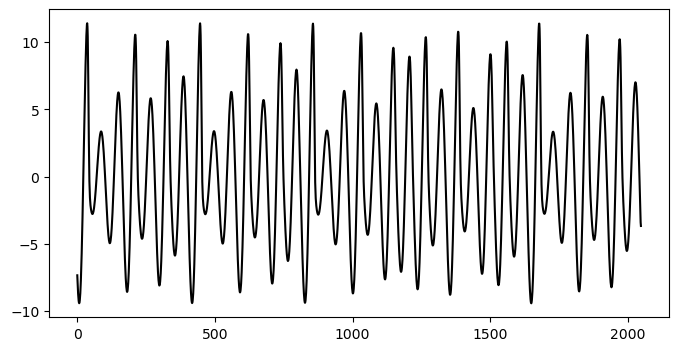

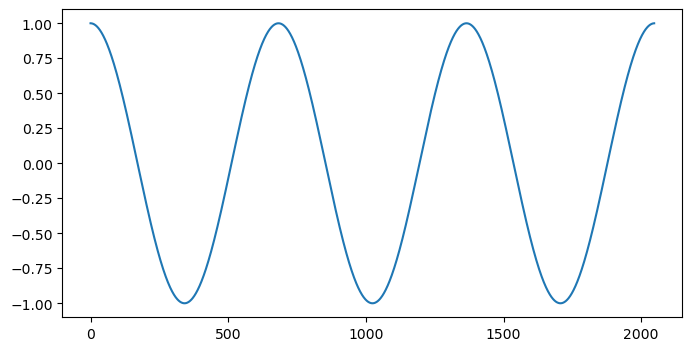

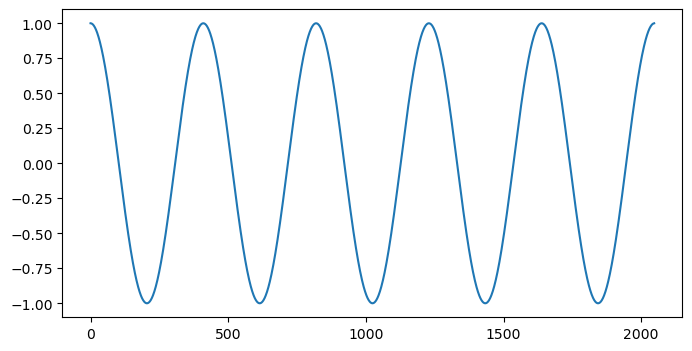

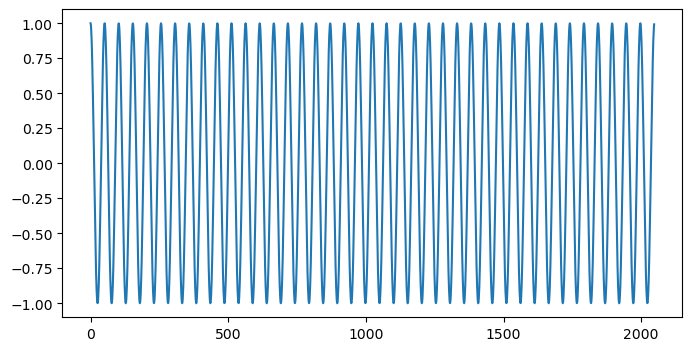

In [32]:
# ## Load the period doubling time series
time_seriesc = yc[:, 0]
time_series2 = y2[:, 0]
time_series4 = y4[:, 0]
time_series8 = y8[:, 0]
plt.figure(figsize=(8, 4))
plt.plot(time_seriesc, 'k')

# ## Create some example basis functions
n = len(time_seriesc)
basis_functions = np.exp(-2j * np.pi * np.arange(n)[:, None] * np.arange(n) / n)
print(basis_functions.shape)
plt.figure(figsize=(8, 4))
plt.plot(basis_functions[3])
plt.figure(figsize=(8, 4))
plt.plot(basis_functions[5])
plt.figure(figsize=(8, 4))
plt.plot(basis_functions[40])

## Implementing the discrete Fourier transform

A discrete approach to this algorithm involves projecting our signal onto a set of "pure" basis functions corresponding to single-frequency (monochromatic) signals. In continuous time, we would have a continuous and uncountable set of frequencies, but for a discrete signal we have a finite number of possible frequency bins spanning $1/N$ to $T/N$, where $T$ is the total time of the signal and $N$ is the number of timepoints.

If our observed signal is $x_n = x_1, x_2, ..., x_N$, then the discrete Fourier transform becomes
$$
X_k = \sum_{n=0}^{N-1} x_n \,e^{-i~2\pi~k~n~/~N}
$$
with corresponding inverse transform
$$
x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}
$$
In our naive implementation below, we compute the set of "pure" functions, and then project the signal onto this basis. This approach is easy to vectorize, since all operations that touch all $N$ elements of the signal can be written as dot products.

We can think of the DFT as a change of basis: we define a set of fixed trigonometric functions, and then project our signal onto these functions. For example, finding a single coefficient $X_3$ in the DFT requires a single dot product between a basis function $e^{-i~2\pi~3~n~/~N} \in \mathbb{C}^N$ and our signal $\mathbf{x} \in \mathbb{R}^N$:

$$
X_3 = \sum_{n=0}^{N-1} x_n e^{-i 2\pi 3n /N} = \mathbf{x} \cdot \mathbf{m}_3
$$
where $\mathbf{m} \in \mathbb{C}^N$ is the basis function for the $k^{th}$ frequency. In order to implement the full DFT, we therefore want to define a set of all basis functions spanning our possible frequencies. We can do this by defining a matrix $M \in \mathbb{C}^{N \times N}$ where each row $M_k$ is the basis function $\mathbf{m}_k = e^{-i~2\pi~k~n~/~N}$.

$$
\mathbf{M} = \begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-i~2\pi~1~/~N} & e^{-i~2\pi~2~/~N} & \cdots & e^{-i~2\pi~(N-1)~/~N} \\
1 & e^{-i~2\pi~2~/~N} & e^{-i~2\pi~4~/~N} & \cdots & e^{-i~2\pi~2(N-1)~/~N} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-i~2\pi~(N-1)~/~N} & e^{-i~2\pi~2(N-1)~/~N} & \cdots & e^{-i~2\pi~(N-1)^2~/~N}
\end{bmatrix}
$$
where $ M_{kn} = e^{-i~2\pi~k~n~/~N}$

In matrix notation, the vectorized DFT therefore becomes
$$
\mathbf{X} = M \cdot \mathbf{x}
$$
where $\mathbf{X} \in \mathbb{C}^N$ is the vector of Fourier coefficients, $\mathbf{x} \in \mathbb{R}^N$ is the vectorized signal, and $M \in \mathbb{C}^{N \times N}$ is the matrix of basis functions.


(512, 512)


([], [])

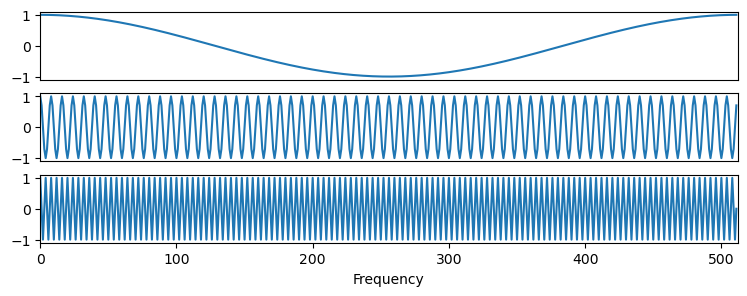

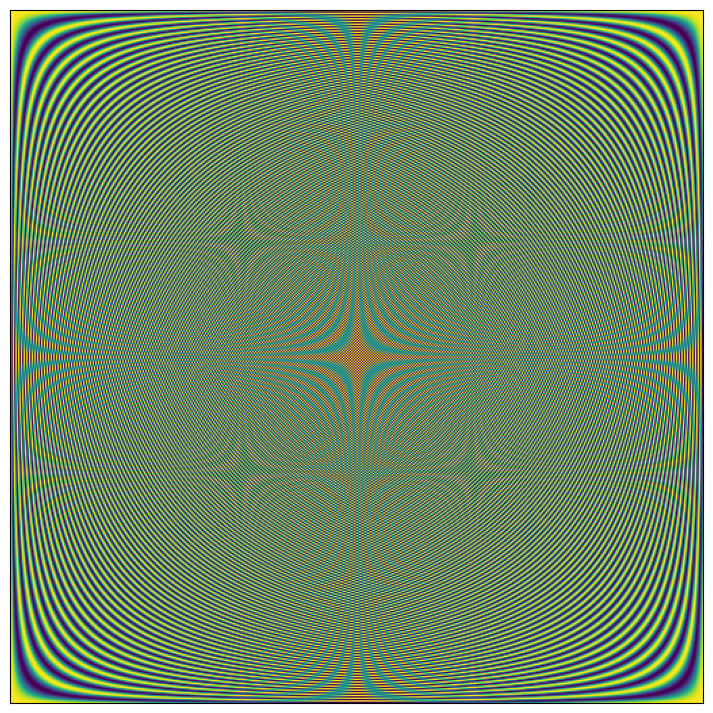

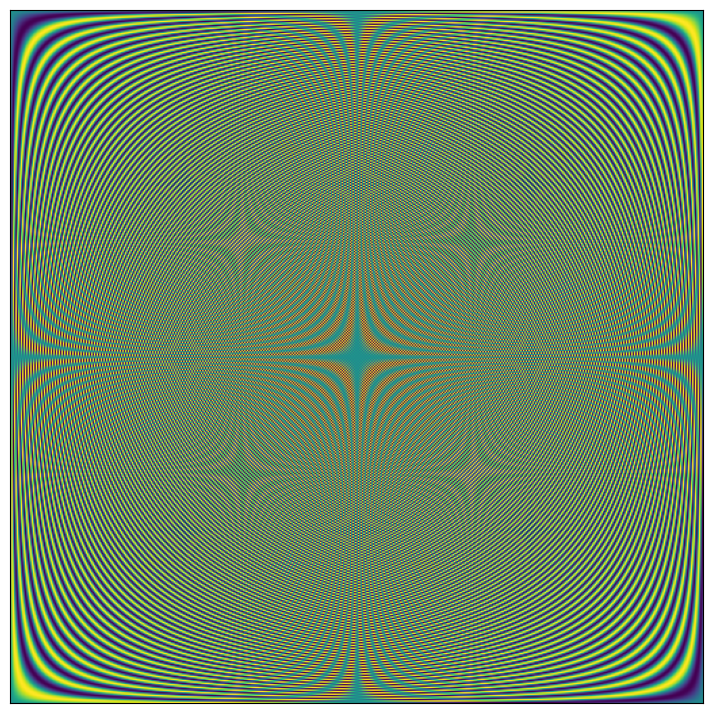

In [21]:
# What does the M matrix look like?

# Python has built-in complex numbers, which numpy supports
N = 512
coeffs = np.exp(-2j * np.pi * np.arange(N)[:, None] * np.arange(N) / N)
print(coeffs.shape)


plt.figure(figsize=(9, 3))
# 3 subplots stacked vertically
plt.subplot(3, 1, 1)
plt.plot(np.real(coeffs)[1])
# plt.title("Second Row")
plt.xlim(0, 512); plt.xticks([])

plt.subplot(3, 1, 2)
plt.plot(np.real(coeffs)[64])
# plt.title("Seventh Row")
plt.xlim(0, 512); plt.xticks([])

plt.subplot(3, 1, 3)
plt.plot(np.real(coeffs)[128])
# plt.title("Highest Frequency Row")
plt.xlim(0, 512)
plt.xlabel("Frequency")



plt.figure(figsize=(9, 9))
plt.imshow(np.real(coeffs), cmap='viridis')
plt.xticks([]); plt.yticks([])


plt.figure(figsize=(9, 9))
plt.imshow(np.imag(coeffs), cmap='viridis')
plt.xticks([]); plt.yticks([])


We can see that that matrix of basis functions has well-defined structure due to patterns in the complex exponentials stored along the rows of the matrix.

### Question:

Why does each frequency appear twice in the DFT M matrix?
<br>
<br>
<br>
<br>
<br>
<br>
<br>


Let's now implement the DFT in Python. We will implement a base class for signal transformations, `SignalTransform`, that handles centering the signal and other common preprocessing steps. The child class `DiscreteFourierTransform` will implement the DFT. One key method of the `SignalTransform` class is the `freq_bounds` method, which computes the upper and lower frequency bounds for a given signal. For a signal with $N$ timepoints, the lowest resolvable frequency is $1/N$ and the highest resolvable frequency is $N/2$.

In [22]:
class SignalTransform:
    """
    A base class for signal transformations

    Parameters:
        center (bool): whether to center the signal before transforming
    """

    def __init__(self, center=True):
        self.center = center

    def preprocess(self, signal):
        if self.center:
            signal -= np.mean(signal, axis=0, keepdims=True)

    def freqbins(self, signal):
        """Compute the zero-centered frequency bins for the FFT of a signal"""
        n = len(signal)
        return np.fft.fftfreq(n, 1 / n)

    # static methods don't require a "self" argument, but also can't
    # access instance attributes. For example, this function can't see the
    # self.center variable that we set in the __init__() constructor
    @staticmethod
    def freq_bounds(signal):
        """Compute upper and lower frequency bounds using the Nyquist criterion"""
        n = len(signal)
        return 1 / (2 * n), n / 2


class DiscreteFourierTransform(SignalTransform):
    """
    An iterative implementation of the discrete Fourier transform

    Vectorized using array broadcasting
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def transform(self, signal):
        """Compute the discrete Fourier transform of a signal"""

        self.preprocess(signal)

        n = len(signal)
        k_vals = np.arange(n)[:, None]

        # Python has built-in complex numbers, which numpy supports
        coeffs = np.exp(-2j * np.pi * k_vals * np.arange(n) / n)

        return np.dot(coeffs, signal)
        # np.matmul
        # return coeffs @ signal
        # return np.einsum('ij,jk->ik', coeffs, signal)

Text(0, 0.5, 'Magnitude')

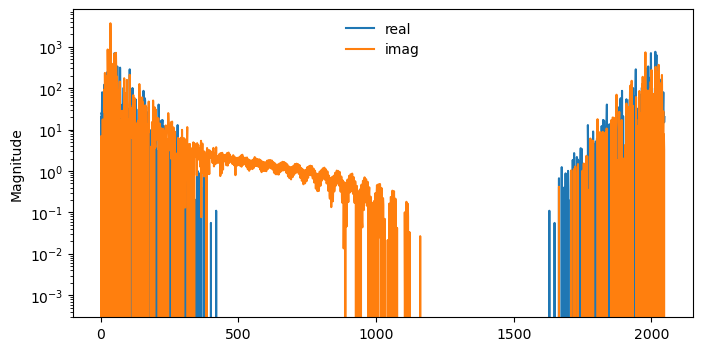

In [23]:

dft = DiscreteFourierTransform()
coeffs = dft.transform(time_seriesc)
# freqs = dft.freqbins(time_seriesc)

plt.figure(figsize=(8, 4))
plt.semilogy(np.real(coeffs), label='real')
plt.semilogy(np.imag(coeffs), label='imag')
# plt.xlim([dft.freq_bounds(ts)[0], dft.freq_bounds(ts)[1]])
# plt.ylim([1e-1, 1e3])
# plt.xlabel('Frequency (Hz)')
plt.legend(frameon=False)
plt.ylabel('Magnitude')

### Finding the power spectral density

We will run the DFT on trajectories from the Rossler system. Since we are particularly interested in the frequencies, we will compute the power spectrum, which is the square of the amplitudes of the DFT coefficients.

We will therefore define a power spectral density object. Notice that the PSD is symmetric, but the Fourier transform is not.

Text(0, 0.5, 'Power')

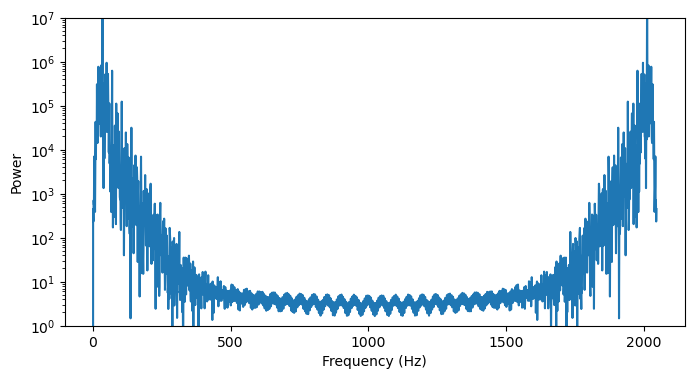

In [24]:
class PowerSpectrum(DiscreteFourierTransform):
    """
    A class that computes the power spectrum of a signal
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def transform(self, signal):
        """Compute the power spectrum of a signal"""

        coeffs = super().transform(signal)
        return np.abs(coeffs) ** 2

## Test that it works
psd = PowerSpectrum()
coeffs = psd.transform(time_seriesc)
plt.figure(figsize=(8, 4))
plt.semilogy(coeffs)
plt.ylim([1, 1e7])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')



Let's now apply the DFT to the Rossler system across the period doubling transition to chaos.

We can see that, as the period doubles, the number of peaks in the power spectrum also doubles. This is a signature of the period-doubling route to chaos. At the critical value of $c$, the system becomes chaotic, and the power spectrum becomes a continuous distribution of frequencies. Chaotic systems are characterized by their broadband frequency content, and are sometimes called continuous spectrum systems

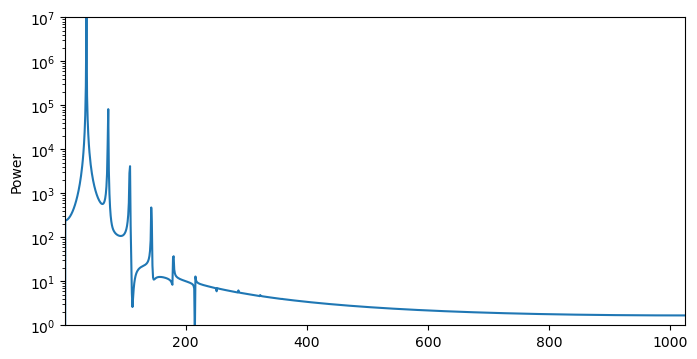

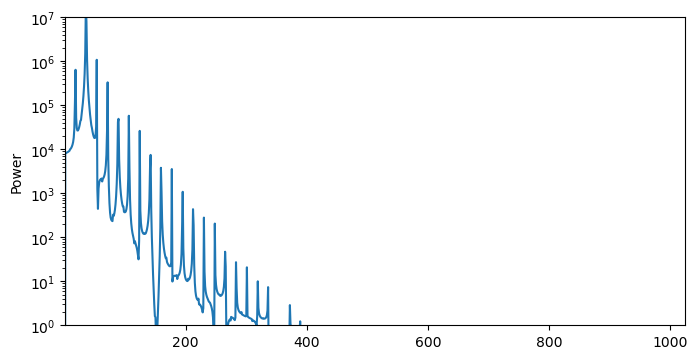

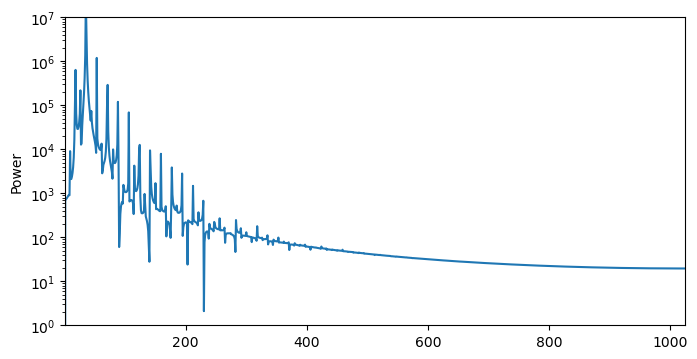

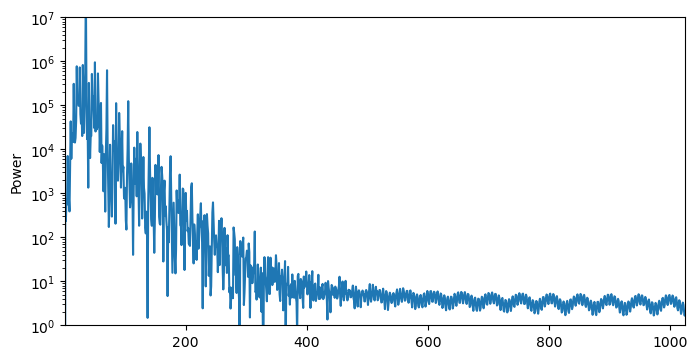

In [25]:

for ts in [time_series2, time_series4, time_series8, time_seriesc]:
    psd = PowerSpectrum()
    coeffs = psd.transform(ts)

    plt.figure(figsize=(8, 4))
    plt.semilogy(coeffs)
    plt.xlim([dft.freq_bounds(ts)[0], dft.freq_bounds(ts)[1]])
    plt.ylim([1, 1e7])
    # plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')



## Questions

+ Notice that our base class includes a `freq_bounds` function. Where do these bounds come from?

+ If our signal contains $N$ timepoints, what do you expect to be the runtime of the our naive DFT implementation?

Text(0, 0.5, 'Time (s)')

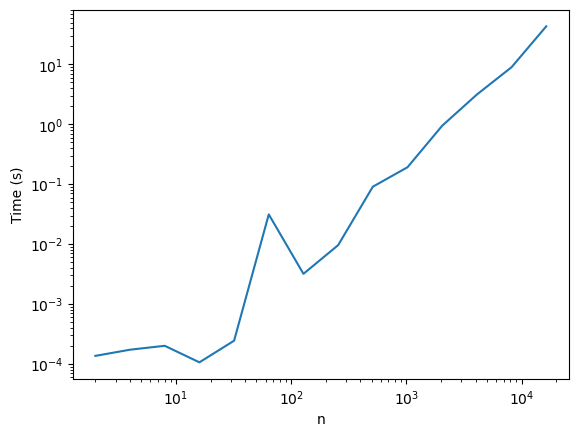

In [26]:
import timeit

n_vals = 2**np.arange(1, 15)

x = np.random.random(int(n_vals[-1])) # Needs to be a power of 2
dft_m = DiscreteFourierTransform()

all_times = []
for n in n_vals:
    time1 = timeit.timeit("dft_m.transform(x[:n])", globals=globals(), number=10)
    all_times.append(time1)
all_times = np.array(all_times)

plt.figure()
plt.loglog(n_vals, all_times)
# plt.loglog(n_vals, n_vals**2 / 2**20, 'k--')
plt.xlabel('n')
plt.ylabel('Time (s)')

### A symmetry in the discrete equations

Recall our definition of the DFT
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
$$
where $k$ is the frequency index and $n$ is the time index. We can split the sum into two parts by separating the even and odd indices of $n$
$$
\begin{align*}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)} \\
\end{align*}
$$




Since our argument does not depend on the specific value of $n$, we now have a clear way to attack this problem:

1. Given a full signal on which to compute the FFT, split the signal into two smaller signals by decimating the original signal by a factor of 2:

$$
x_{\rm even} = x_0, x_2, x_4, ..., x_{N-2} \\
x_{\rm odd} = x_1, x_3, x_5, ..., x_{N-1}
$$

2. Compute the FFT of each of the two smaller signals.

$$
X_{\rm even} = \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} \\
X_{\rm odd} = \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
$$

3. Combine the two FFTs into a single FFT of the full signal.

$$
X_k = X_{\rm even} + e^{-i~2\pi~k~/~N} X_{\rm odd}
$$

Recall that the index into $X_{\rm even}$ is given by $k$. The sign of $e^{-i~2\pi~k~/~N}$ is determined by the frequency index $k$. When $k > N/2$, the sign is negative, and when $k \leq N/2$, the sign is positive. This is the key to the symmetry of the DFT: If we take the FFT of the even and odd parts of the signal, we end up *concatenating* the two FFTs to form the full FFT. This is the key to the "fast" in the Fast Fourier Transform.



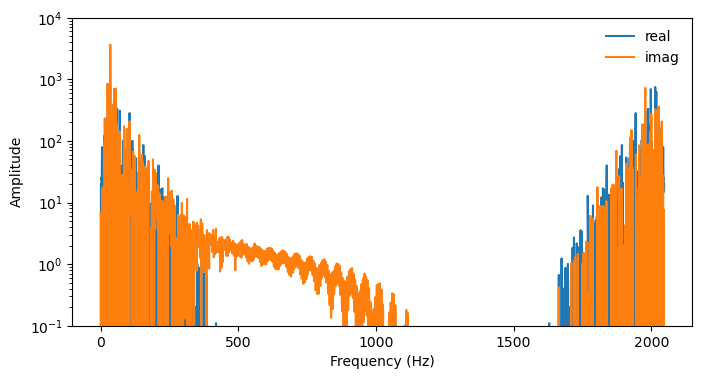

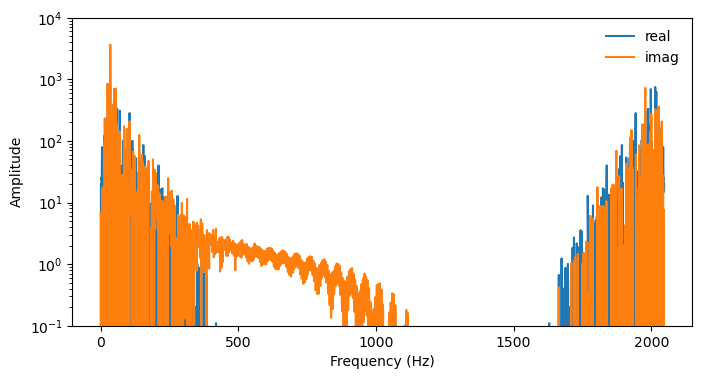

In [27]:
n = len(time_seriesc)

dft = DiscreteFourierTransform()
coeffs = dft.transform(time_seriesc) # T = 500

plt.figure(figsize=(8, 4))
plt.semilogy(np.real(coeffs), label='real')
plt.semilogy(np.imag(coeffs), label='imag')
plt.ylim([0.1, 1e4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(frameon=False)


time_series_even = time_seriesc[::2] # T = 250
time_series_odd = time_seriesc[1::2] # T = 250
coeffs_even = dft.transform(time_series_even)
coeffs_odd = dft.transform(time_series_odd)

# # # combine into the full DFT by concatenating two arrays
coeffs_overall = np.zeros_like(coeffs) # set aside empty array of length N
coeffs_overall[:n//2] = coeffs_even + np.exp(-2j * np.pi * np.arange(n // 2) / n) * coeffs_odd
coeffs_overall[n//2:] = coeffs_even - np.exp(-2j * np.pi * np.arange(n // 2) / n) * coeffs_odd
plt.figure(figsize=(8, 4))
plt.semilogy(np.real(coeffs_overall), label='real')
plt.semilogy(np.imag(coeffs_overall), label='imag')
plt.ylim([0.1, 1e4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(frameon=False)





## What is the DFT of a time series with one point?

Consider our definition of the DFT
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
$$

Let's set $N = 1$ and simplify the sum,
$$
X_k = x_0 \cdot e^{-i~2\pi~k~0~/~1} = x_0
$$

<br>
<br>
<br>
<br>
<br>



## The Fast Fourier Transform

Why stop at just one split? We can continue to split the signal into smaller and smaller subarrays, yielding the following algorithm:

1. Given a full signal on which to compute the FFT, split the signal into two smaller signals by decimating the original signal by a factor of 2.

2. If the length of the two subarrays is greater than 2, then split each of the two subarrays into two smaller subarrays,

3. Proceed recursively until the length of the subarrays is 1, at which point the DFT is trivial to compute.

$$
    FFT(x) = \begin{cases}
    x & \text{if } N = 1 \\
    \begin{bmatrix}
    FFT(x_{\rm even}) + e^{-i~2\pi~k~/~N} FFT(x_{\rm odd}) \\
    FFT(x_{\rm even}) - e^{-i~2\pi~k~/~N} FFT(x_{\rm odd})
    \end{bmatrix} & \text{if } N > 1
    \end{cases}
$$

4. Now combine the DFTs of the two single-element subarrays using our results from above

$$
    X_k = X_{\rm even} + e^{-i~2\pi~k~/~N} X_{\rm odd}
$$

This will double the length of the subarray, so we now have a subarray of length 2.

5. Now repeat Step 4 until we have the full DFT of the original signal.



<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/fft.png" alt="FFT Source" style="width: 750px;"/>

*Image from [Source](https://riptutorial.com/algorithm/example/27088/radix-2-fft)*



## Recursion

The FFT is naturally suited to recursion, with the short length-1 and length-2 signal cases representing *base cases* for returns. This approach is known as divide-and-conquer.

We will define a function `fft` that takes a signal and returns its DFT. The function will split the signal and then call itself, until it hits a "Base Case" where the signal is length 1 or 2. At this point, it will return the trivial DFT of the signal. The function will then combine the DFTs of the two subarrays and return the full DFT of the original signal.

In [28]:

class FastFourierTransform(SignalTransform):
    """
    A recursive implementation of the fast Fourier transform
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def transform(self, signal):

        n = len(signal)

        # base case; stop recursion when an array of length 1 is reached
        if n == 1:
            return signal

        # base case; stop recursion when an array of length 1 is reached
        else:
            ## Decimate the signal by 2, then call the function itself on the decimated signal
            signal_even = self.transform(signal[::2])
            signal_odd = self.transform(signal[1::2])
            coeffs = np.exp(-2j * np.pi * np.arange(n) / n)
            signal_new =  np.hstack([
                signal_even + coeffs[:(n // 2)] * signal_odd,
                signal_even + coeffs[(n // 2):] * signal_odd
            ])
            return signal_new


Text(0, 0.5, 'Amplitude')

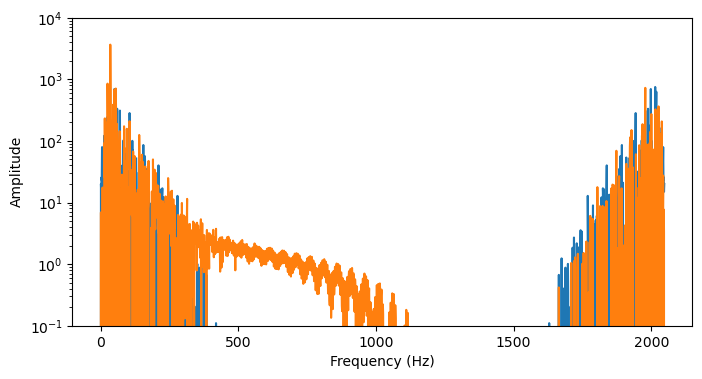

In [29]:
# x = np.random.random(2**8)
fft = FastFourierTransform()
coeffs = fft.transform(time_seriesc)

plt.figure(figsize=(8, 4))
plt.semilogy(np.real(coeffs))
plt.semilogy(np.imag(coeffs))
plt.ylim([0.1, 1e4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

## Runtime complexity of the FFT

We will use the built-in `numpy.fft.fft` function to check that our implementation is correct. While the vanilla DFT has runtime complexity $N^2$ due to the need to compute $N$ dot products for each of the $N$ pure frequency components, the FFT has runtime $N \log N$ because it reduces the problem in each step


In [30]:
x = np.random.random(2**10) # Needs to be a power of 2

dft_m = DiscreteFourierTransform()
%timeit dft_m.transform(x)
# check that it matches numpy's implementation
print(np.allclose(dft_m.transform(x), np.fft.fft(x)))

fft_m = FastFourierTransform()
%timeit fft_m.transform(x)
# check that it matches numpy's implementation
print(np.allclose(fft_m.transform(x), np.fft.fft(x)))

20.9 ms ± 618 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
3.8 ms ± 36.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


Text(0, 0.5, 'Time (s)')

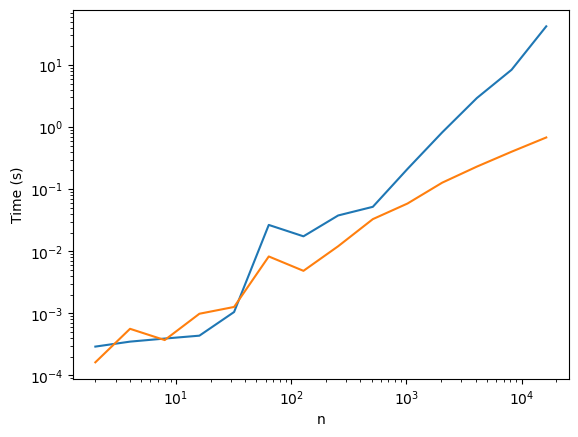

In [31]:
import timeit

n_vals = 2**np.arange(1, 15)

x = np.random.random(int(n_vals[-1])) # Needs to be a power of 2
dft_m = DiscreteFourierTransform()
fft_m = FastFourierTransform()

all_times = []
for n in n_vals:
    time1 = timeit.timeit("dft_m.transform(x[:n])", globals=globals(), number=10)
    time2 = timeit.timeit("fft_m.transform(x[:n])", globals=globals(), number=10)
    all_times.append([time1, time2])
all_times = np.array(all_times)

plt.figure()
plt.loglog(n_vals, all_times[:, 0])
plt.loglog(n_vals, all_times[:, 1])
plt.xlabel('n')
plt.ylabel('Time (s)')

We can see that the FFT is asymptotically faster than the DFT, and the runtime is $ \mathcal{O}(N \log_2(N))$.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Continuous spectrum dynamical systems

Another term for chaotic systems is continuous-spectrum systems. This is because the power spectrum of a chaotic system is continuous, meaning that oscillations appear at a continuum of frequencies. These can be thought of as interacting modes, or excitations, of the system.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/swinney_gollub2.png" alt="Gollub Swinney PRL header" style="width: 750px;"/>
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/swinney_gollub1.png" alt="Gollub Swinney PRL Fig 1" style="width: 750px;"/>

*Image from [Gollub & Swinney (1975)](https://doi.org/10.1103/PhysRevLett.35.927)*

<br>
<br>
<br>
<br>
<br>
<br>
<br>
